In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:
df_cleaned = pd.read_csv('cleaned_aquair_data.csv')
# Define feature columns and target column
feature_columns = ['temp', 'humid', 'co2', 'voc', 'pm25', 'pm10', 
                   'hour', 'day', 'month', 'year', 'dayofweek']
target_column = 'score'
X = df_cleaned[feature_columns].values
y = df_cleaned[target_column].values

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (23856, 11)
Target shape: (23856,)


In [3]:
def create_sequences(X, y, sequence_length):
    """
    Create sequences for time series forecasting.
    Each sequence contains 'sequence_length' time steps to predict the next value.
    """
    X_sequences = []
    y_sequences = []
    
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])
    
    return np.array(X_sequences), np.array(y_sequences)

# Define sequence length (number of past time steps to use for prediction)
sequence_length = 24  # Use 24 past observations to predict the next one

# Create sequences
X_seq, y_seq = create_sequences(X, y, sequence_length)

print("Sequence features shape:", X_seq.shape)
print("Sequence target shape:", y_seq.shape)


Sequence features shape: (23832, 24, 11)
Sequence target shape: (23832,)


In [5]:
train_size = int(0.6 * len(X_seq))
val_size = int(0.2 * len(X_seq))
# test_size will be the remaining 20%

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X_seq)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X_seq)*100:.1f}%)")

Training set size: 14299 (60.0%)
Validation set size: 4766 (20.0%)
Test set size: 4767 (20.0%)


In [6]:
# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data only
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Transform validation and test data using the same scalers
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()


In [7]:
class AirQualityDataset(Dataset):
    """Custom Dataset for air quality time series data"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = AirQualityDataset(X_train_scaled, y_train_scaled)
val_dataset = AirQualityDataset(X_val_scaled, y_val_scaled)
test_dataset = AirQualityDataset(X_test_scaled, y_test_scaled)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class TemporalBlock(nn.Module):
    """Temporal Block for TCN with proper causal padding"""
    
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        # Calculate padding for causal convolution
        padding = (kernel_size - 1) * dilation
        
        # First convolution
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(n_inputs, n_outputs, kernel_size,
                     stride=stride, padding=padding, dilation=dilation)
        )
        
        # Second convolution
        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(n_outputs, n_outputs, kernel_size,
                     stride=stride, padding=padding, dilation=dilation)
        )
        
        # Downsample if input and output channels don't match
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        
        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # Store parameters for padding removal
        self.padding = padding
        self.kernel_size = kernel_size
        self.dilation = dilation
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('relu'))
        if self.downsample is not None:
            nn.init.xavier_uniform_(self.downsample.weight, gain=nn.init.calculate_gain('relu'))
        
        # Initialize biases to zero
        nn.init.constant_(self.conv1.bias, 0)
        nn.init.constant_(self.conv2.bias, 0)
        if self.downsample is not None:
            nn.init.constant_(self.downsample.bias, 0)
    
    def forward(self, x):
        # Store residual (before any padding removal)
        residual = x
        
        # First convolution
        out = self.conv1(x)
        # Remove excess padding from the end (causal convolution)
        if self.padding != 0:
            out = out[:, :, :-self.padding] if self.padding != 0 else out
        out = self.relu(out)
        out = self.dropout(out)
        
        # Second convolution
        out = self.conv2(out)
        # Remove excess padding from the end
        if self.padding != 0:
            out = out[:, :, :-self.padding] if self.padding != 0 else out
        out = self.relu(out)
        out = self.dropout(out)
        
        # Apply downsample if needed
        if self.downsample is not None:
            residual = self.downsample(residual)
        
        # Add residual connection - ensure same dimensions
        # Trim residual if needed (should be same as out after padding removal)
        if residual.size(2) != out.size(2):
            # If different, trim residual to match output
            residual = residual[:, :, :out.size(2)]
        
        out = out + residual
        
        return out


class TCNModel(nn.Module):
    """Temporal Convolutional Network for time series forecasting"""
    
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.dropout = dropout
        
        # Create TCN layers
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i  # Exponential dilation
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            
            layers += [
                TemporalBlock(
                    in_channels, 
                    out_channels, 
                    kernel_size, 
                    stride=1, 
                    dilation=dilation_size,
                    dropout=dropout
                )
            ]
        
        self.tcn = nn.Sequential(*layers)
        
        # Calculate receptive field
        self.receptive_field = 1
        for i in range(num_levels):
            dilation = 2 ** i
            self.receptive_field += (kernel_size - 1) * dilation
        
        # Fully connected layer for prediction
        self.fc = nn.Linear(num_channels[-1], output_size)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        """Initialize weights for the fully connected layer"""
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias, 0.0)
    
    def forward(self, x):
        """
        Forward pass
        x shape: (batch_size, sequence_length, input_size)
        """
        # Reshape for Conv1d: (batch_size, input_size, sequence_length)
        x = x.transpose(1, 2)
        
        # Pass through TCN
        out = self.tcn(x)
        
        # Take output from the last time step
        out = out[:, :, -1]
        
        # Fully connected layer
        out = self.fc(out)
        
        return out.squeeze()

In [13]:
input_size = len(feature_columns)
output_size = 1
# TCN architecture parameters
sequence_length = 24  # Make sure this is defined
num_channels = [64, 64, 64, 64]  # 4 layers for better receptive field
kernel_size = 3
dropout = 0.2

# Create model
model = TCNModel(
    input_size=input_size,
    output_size=output_size,
    num_channels=num_channels,
    kernel_size=kernel_size,
    dropout=dropout
)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("Loss function: Mean Squared Error")
print("Optimizer: AdamW with learning rate 0.001, weight_decay 0.01")
print("Scheduler: ReduceLROnPlateau")

Loss function: Mean Squared Error
Optimizer: AdamW with learning rate 0.001, weight_decay 0.01
Scheduler: ReduceLROnPlateau


In [15]:
def train_tcn_model(model, train_loader, val_loader, criterion, optimizer, 
                   scheduler, num_epochs, patience=15, grad_clip=1.0):
    """Train the TCN model with early stopping"""
    
    train_losses = []
    val_losses = []
    learning_rates = []
    grad_norms = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = 0
        epoch_grad_norm = 0
        batch_count = 0
        
        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            total_norm = torch.nn.utils.clip_grad_norm_(
                model.parameters(), 
                max_norm=grad_clip
            )
            epoch_grad_norm += total_norm.item()
            batch_count += 1
            
            optimizer.step()
            
            train_epoch_loss += loss.item()
        
        avg_train_loss = train_epoch_loss / len(train_loader)
        avg_grad_norm = epoch_grad_norm / batch_count if batch_count > 0 else 0
        
        train_losses.append(avg_train_loss)
        grad_norms.append(avg_grad_norm)
        
        model.eval()
        val_epoch_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_epoch_loss += loss.item()
        
        avg_val_loss = val_epoch_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        # Track current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, 'best_tcn_checkpoint.pth')
            
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'Train Loss: {avg_train_loss:.4f} | '
                  f'Val Loss: {avg_val_loss:.4f} * | '
                  f'LR: {current_lr:.6f} | '
                  f'Grad Norm: {avg_grad_norm:.2f}')
        else:
            patience_counter += 1
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'Train Loss: {avg_train_loss:.4f} | '
                  f'Val Loss: {avg_val_loss:.4f} | '
                  f'LR: {current_lr:.6f} | '
                  f'Grad Norm: {avg_grad_norm:.2f}')
        
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nLoaded best model with validation loss: {best_val_loss:.4f}")
    
    return train_losses, val_losses, learning_rates, grad_norms


In [16]:
num_epochs = 100
patience = 15
grad_clip = 1.0

print(f"Epochs: {num_epochs}")
print(f"Patience: {patience}")
print(f"Gradient clipping: {grad_clip}")

train_losses, val_losses, learning_rates, grad_norms = train_tcn_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    patience=patience,
    grad_clip=grad_clip
)

Epochs: 100
Patience: 15
Gradient clipping: 1.0
Epoch [  1/100] | Train Loss: 0.0532 | Val Loss: 0.0392 * | LR: 0.001000 | Grad Norm: 1.09
Epoch [  2/100] | Train Loss: 0.0074 | Val Loss: 0.0418 | LR: 0.001000 | Grad Norm: 0.35
Epoch [  3/100] | Train Loss: 0.0061 | Val Loss: 0.0314 * | LR: 0.001000 | Grad Norm: 0.31
Epoch [  4/100] | Train Loss: 0.0052 | Val Loss: 0.0496 | LR: 0.001000 | Grad Norm: 0.26
Epoch [  5/100] | Train Loss: 0.0049 | Val Loss: 0.0460 | LR: 0.001000 | Grad Norm: 0.25
Epoch [  6/100] | Train Loss: 0.0050 | Val Loss: 0.0324 | LR: 0.001000 | Grad Norm: 0.26
Epoch [  7/100] | Train Loss: 0.0046 | Val Loss: 0.0329 | LR: 0.001000 | Grad Norm: 0.24
Epoch [  8/100] | Train Loss: 0.0042 | Val Loss: 0.0341 | LR: 0.001000 | Grad Norm: 0.21
Epoch [  9/100] | Train Loss: 0.0048 | Val Loss: 0.0356 | LR: 0.000500 | Grad Norm: 0.24
Epoch [ 10/100] | Train Loss: 0.0035 | Val Loss: 0.0298 * | LR: 0.000500 | Grad Norm: 0.17
Epoch [ 11/100] | Train Loss: 0.0032 | Val Loss: 0.0293 

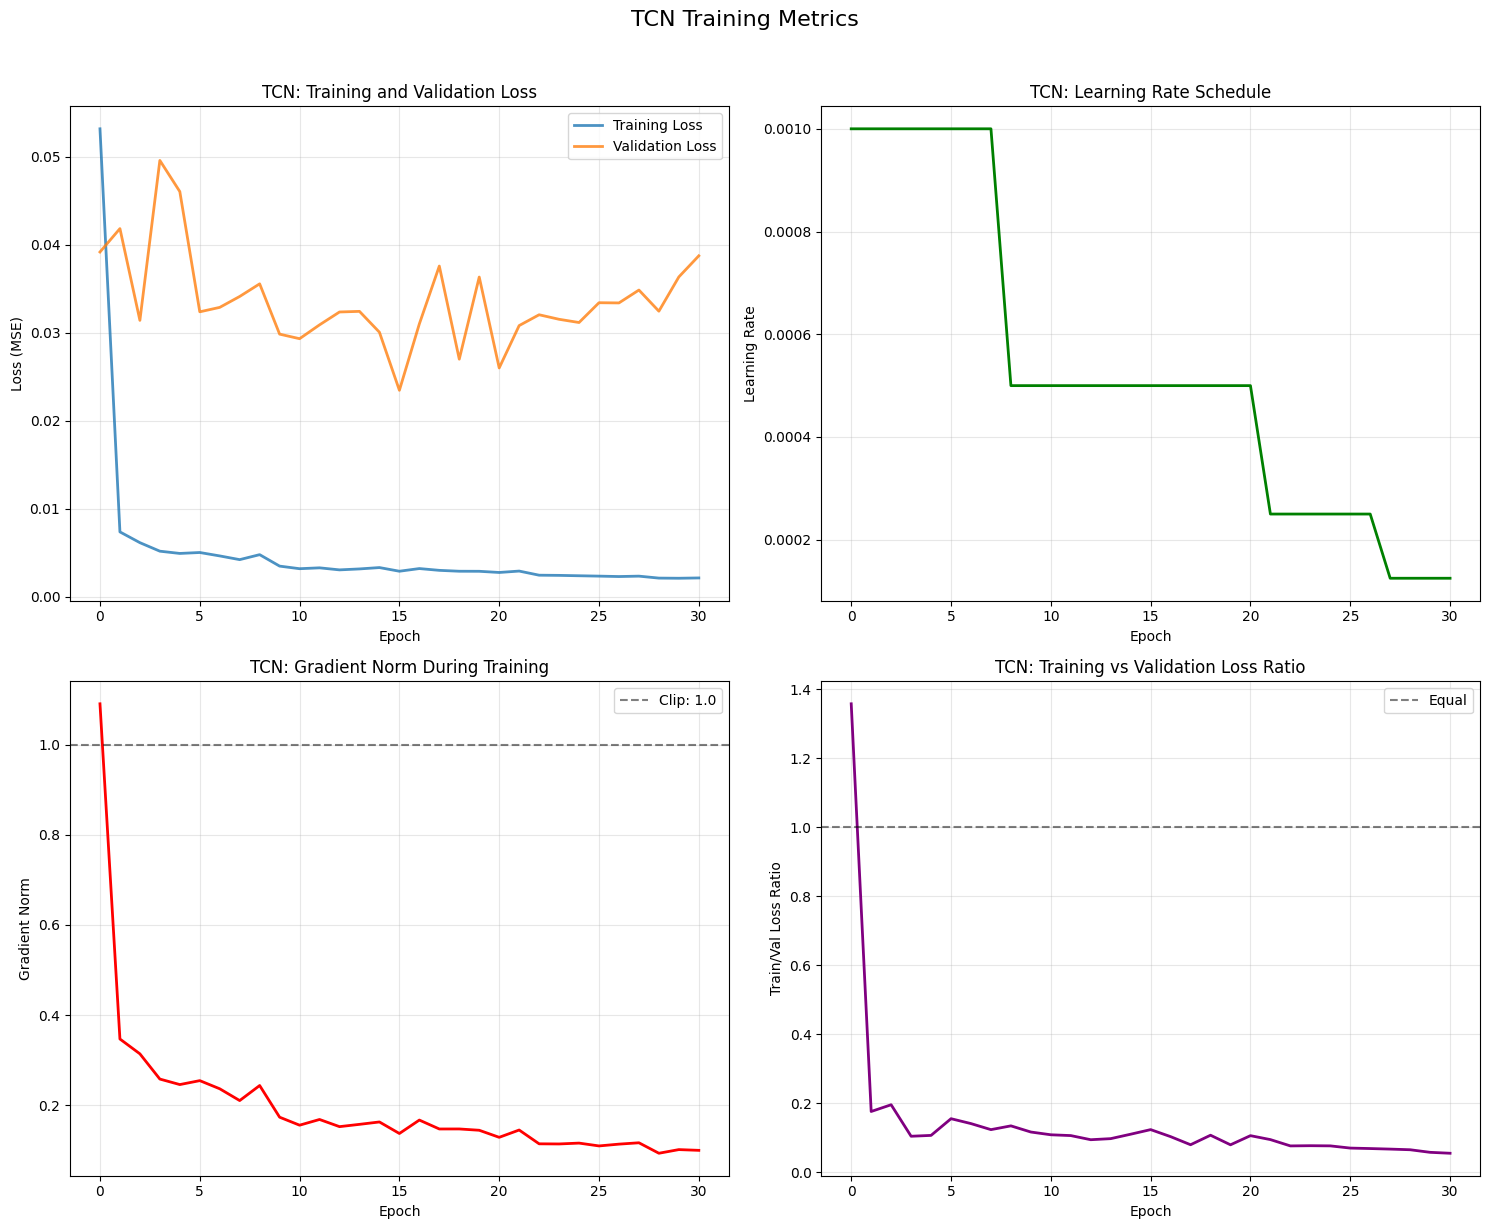

In [19]:
def plot_tcn_training_metrics(train_losses, val_losses, learning_rates, grad_norms):
    """Plot TCN training metrics"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Training and validation loss
    axes[0, 0].plot(train_losses, label='Training Loss', linewidth=2, alpha=0.8)
    axes[0, 0].plot(val_losses, label='Validation Loss', linewidth=2, alpha=0.8)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('TCN: Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Learning rate schedule
    axes[0, 1].plot(learning_rates, color='green', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('TCN: Learning Rate Schedule')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Gradient norms
    axes[1, 0].plot(grad_norms, color='red', linewidth=2)
    axes[1, 0].axhline(y=grad_clip, color='black', linestyle='--', alpha=0.5, label=f'Clip: {grad_clip}')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Gradient Norm')
    axes[1, 0].set_title('TCN: Gradient Norm During Training')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Loss ratio (train/val)
    if len(val_losses) > 0 and len(train_losses) > 0:
        loss_ratio = [t/v if v > 0 else 0 for t, v in zip(train_losses, val_losses)]
        axes[1, 1].plot(loss_ratio, color='purple', linewidth=2)
        axes[1, 1].axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Train/Val Loss Ratio')
        axes[1, 1].set_title('TCN: Training vs Validation Loss Ratio')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('TCN Training Metrics', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_tcn_training_metrics(train_losses, val_losses, learning_rates, grad_norms)

In [20]:
def evaluate_tcn_model(model, data_loader, scaler_y, set_name="Validation"):
    """Evaluate the TCN model"""
    
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            predictions.extend(outputs.numpy())
            actuals.extend(batch_y.numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    # Inverse transform to get original scale
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    # Calculate metrics
    mse = np.mean((predictions - actuals) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - actuals))
    
    # Calculate R-squared
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Mean Absolute Percentage Error
    non_zero_mask = actuals != 0
    if np.any(non_zero_mask):
        mape = np.mean(np.abs((actuals[non_zero_mask] - predictions[non_zero_mask]) / 
                             actuals[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    print(f"\n{set_name.upper()} SET EVALUATION:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    if not np.isnan(mape):
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    return predictions, actuals, {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}


val_predictions, val_actuals, val_metrics = evaluate_tcn_model(
    model, val_loader, scaler_y, "Validation"
)



VALIDATION SET EVALUATION:
Mean Squared Error (MSE): 31.2891
Root Mean Squared Error (RMSE): 5.5937
Mean Absolute Error (MAE): 3.7411
R-squared (R²): 0.9792
Mean Absolute Percentage Error (MAPE): 140747040.00%


In [21]:
print("TCN MODEL TESTING")
test_predictions, test_actuals, test_metrics = evaluate_tcn_model(
    model, test_loader, scaler_y, "Test"
)


TCN MODEL TESTING

TEST SET EVALUATION:
Mean Squared Error (MSE): 212.9339
Root Mean Squared Error (RMSE): 14.5923
Mean Absolute Error (MAE): 13.0966
R-squared (R²): -0.4011
Mean Absolute Percentage Error (MAPE): 40.79%


TCN VALIDATION SET VISUALIZATION


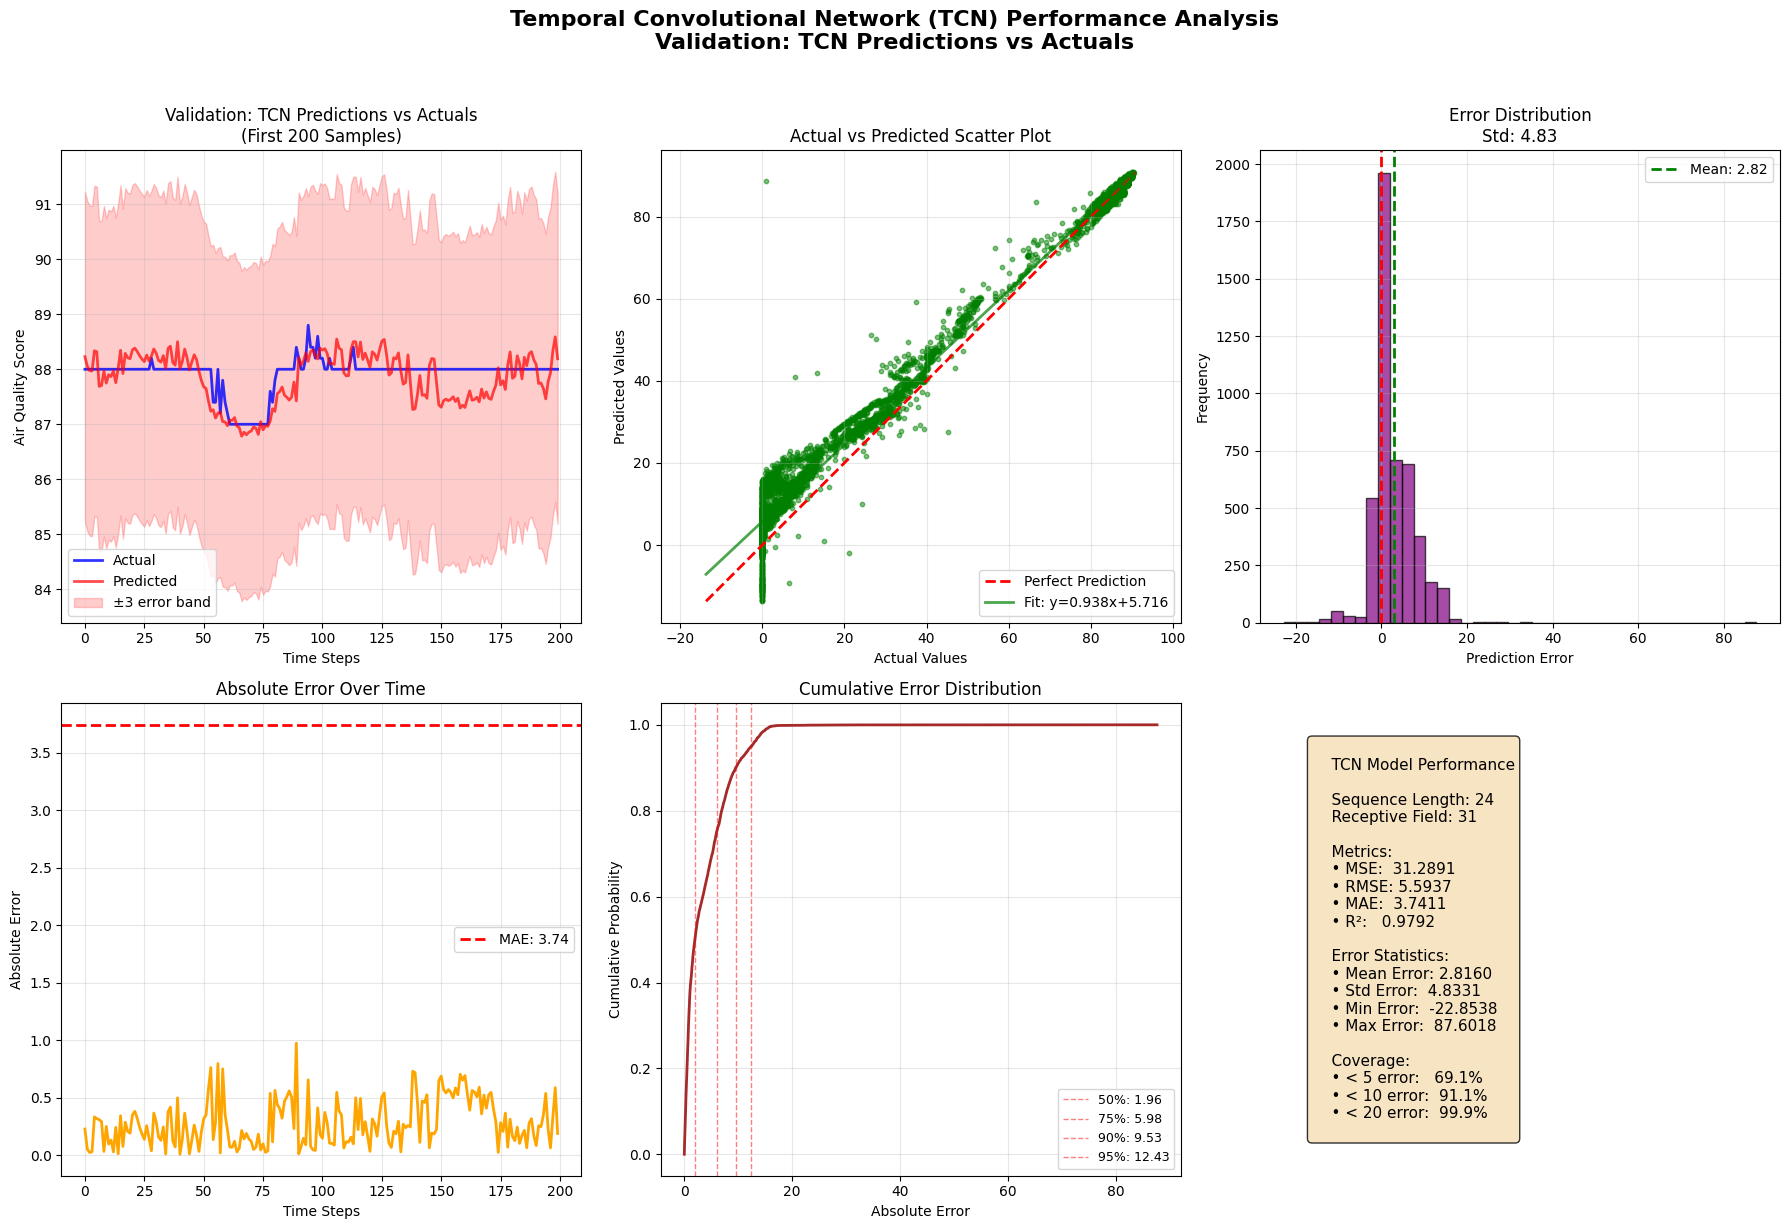

TCN TEST SET VISUALIZATION


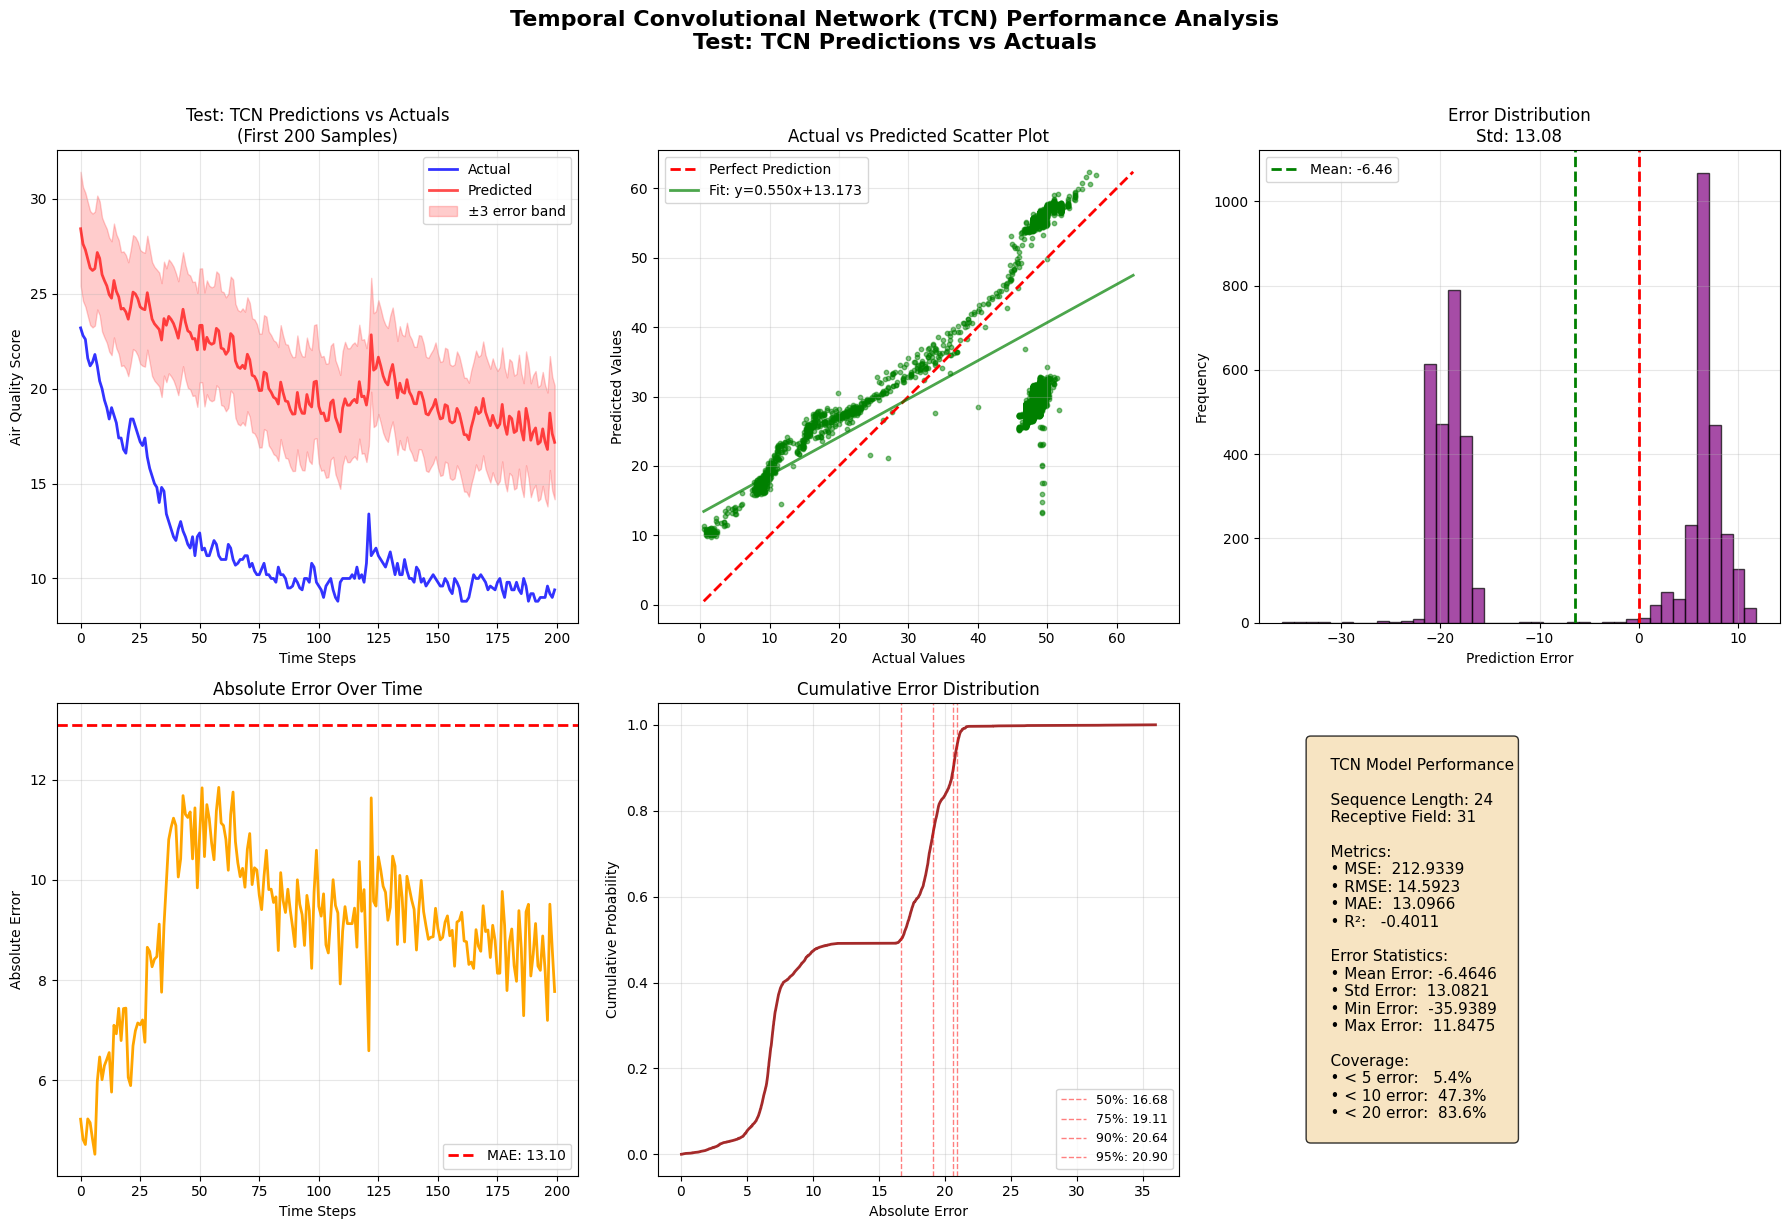

In [22]:
def plot_tcn_predictions(actuals, predictions, title="TCN Predictions vs Actuals", 
                        sequence_length=24, receptive_field=0):
    """
    Create comprehensive prediction visualization for TCN models
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Time series comparison
    sample_size = min(200, len(actuals))
    axes[0, 0].plot(actuals[:sample_size], label='Actual', alpha=0.8, linewidth=2, color='blue')
    axes[0, 0].plot(predictions[:sample_size], label='Predicted', alpha=0.7, linewidth=2, color='red')
    axes[0, 0].fill_between(range(sample_size), 
                           predictions[:sample_size].flatten() - 3,
                           predictions[:sample_size].flatten() + 3,
                           alpha=0.2, color='red', label='±3 error band')
    axes[0, 0].set_xlabel('Time Steps')
    axes[0, 0].set_ylabel('Air Quality Score')
    axes[0, 0].set_title(f'{title}\n(First {sample_size} Samples)', fontsize=12)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot
    axes[0, 1].scatter(actuals, predictions, alpha=0.5, s=10, color='green')
    min_val = min(actuals.min(), predictions.min())
    max_val = max(actuals.max(), predictions.max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 
                   'r--', linewidth=2, label='Perfect Prediction')
    
    # Add regression line
    if len(actuals) > 1:
        z = np.polyfit(actuals.flatten(), predictions.flatten(), 1)
        p = np.poly1d(z)
        axes[0, 1].plot([min_val, max_val], p([min_val, max_val]), 
                       'g-', linewidth=2, alpha=0.7, label=f'Fit: y={z[0]:.3f}x+{z[1]:.3f}')
    
    axes[0, 1].set_xlabel('Actual Values')
    axes[0, 1].set_ylabel('Predicted Values')
    axes[0, 1].set_title('Actual vs Predicted Scatter Plot', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axis('equal')
    
    # Plot 3: Error distribution
    errors = predictions - actuals
    axes[0, 2].hist(errors, bins=40, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 2].axvline(x=np.mean(errors), color='green', linestyle='--', 
                      linewidth=2, label=f'Mean: {np.mean(errors):.2f}')
    axes[0, 2].set_xlabel('Prediction Error')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title(f'Error Distribution\nStd: {np.std(errors):.2f}', fontsize=12)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Absolute error over time
    axes[1, 0].plot(np.abs(errors[:sample_size]), color='orange', linewidth=2)
    axes[1, 0].axhline(y=np.mean(np.abs(errors)), color='red', linestyle='--', 
                      linewidth=2, label=f'MAE: {np.mean(np.abs(errors)):.2f}')
    axes[1, 0].set_xlabel('Time Steps')
    axes[1, 0].set_ylabel('Absolute Error')
    axes[1, 0].set_title('Absolute Error Over Time', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Cumulative error distribution
    sorted_abs_errors = np.sort(np.abs(errors.flatten()))
    cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors)
    axes[1, 1].plot(sorted_abs_errors, cumulative, linewidth=2, color='brown')
    
    # Add percentile lines
    for percentile in [50, 75, 90, 95]:
        threshold = np.percentile(sorted_abs_errors, percentile)
        axes[1, 1].axvline(x=threshold, color='red', linestyle='--', alpha=0.5, 
                          linewidth=1, label=f'{percentile}%: {threshold:.2f}')
    
    axes[1, 1].set_xlabel('Absolute Error')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Error Distribution', fontsize=12)
    axes[1, 1].legend(loc='lower right', fontsize=9)
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: TCN-specific info and metrics
    axes[1, 2].axis('off')
    
    # Calculate additional metrics
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(errors))
    r2 = 1 - (np.sum(errors ** 2) / np.sum((actuals - np.mean(actuals)) ** 2))
    
    # Create text box with metrics
    metrics_text = f"""
    TCN Model Performance
    
    Sequence Length: {sequence_length}
    Receptive Field: {receptive_field}
    
    Metrics:
    • MSE:  {mse:.4f}
    • RMSE: {rmse:.4f}
    • MAE:  {mae:.4f}
    • R²:   {r2:.4f}
    
    Error Statistics:
    • Mean Error: {np.mean(errors):.4f}
    • Std Error:  {np.std(errors):.4f}
    • Min Error:  {np.min(errors):.4f}
    • Max Error:  {np.max(errors):.4f}
    
    Coverage:
    • < 5 error:   {(np.abs(errors) < 5).mean()*100:.1f}%
    • < 10 error:  {(np.abs(errors) < 10).mean()*100:.1f}%
    • < 20 error:  {(np.abs(errors) < 20).mean()*100:.1f}%
    """
    
    axes[1, 2].text(0.1, 0.5, metrics_text, fontsize=11, 
                   verticalalignment='center', 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle(f'Temporal Convolutional Network (TCN) Performance Analysis\n{title}', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return errors

# Plot validation predictions
print("TCN VALIDATION SET VISUALIZATION")
val_errors = plot_tcn_predictions(
    val_actuals, val_predictions, 
    title="Validation: TCN Predictions vs Actuals",
    sequence_length=sequence_length,
    receptive_field=model.receptive_field
)

# Plot test predictions
print("TCN TEST SET VISUALIZATION")
test_errors = plot_tcn_predictions(
    test_actuals, test_predictions, 
    title="Test: TCN Predictions vs Actuals",
    sequence_length=sequence_length,
    receptive_field=model.receptive_field
)


In [23]:
def analyze_temporal_performance(model, test_loader, scaler_y, sequence_length):
    """
    Analyze how TCN performs across different prediction horizons
    """
    model.eval()
    
    # Collect predictions and actuals
    all_predictions = []
    all_actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            all_predictions.extend(outputs.numpy())
            all_actuals.extend(batch_y.numpy())
    
    # Convert and inverse transform
    predictions = np.array(all_predictions).reshape(-1, 1)
    actuals = np.array(all_actuals).reshape(-1, 1)
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    # Analyze by time of day (if hour is a feature)
    hour_index = feature_columns.index('hour') if 'hour' in feature_columns else -1
    
    if hour_index >= 0:
        print("TCN PERFORMANCE BY HOUR OF DAY")
        hour_predictions = {}
    return predictions, actuals

In [ ]:
def save_tcn_model(model, scaler_X, scaler_y, feature_columns, sequence_length, 
                  train_losses, val_losses, test_metrics, config):
    """Save the TCN model and all training artifacts"""
    
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_size': len(feature_columns),
            'output_size': 1,
            'num_channels': num_channels,
            'kernel_size': kernel_size,
            'dropout': dropout,
            'receptive_field': model.receptive_field,
            'sequence_length': sequence_length
        },
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_columns': feature_columns,
        'sequence_length': sequence_length,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_metrics': test_metrics,
        'training_params': {
            'batch_size': batch_size,
            'learning_rate': 0.001,
            'weight_decay': 0.01,
            'grad_clip': grad_clip,
            'num_epochs': num_epochs,
            'patience': patience
        }
    }
    
    torch.save(save_dict, 'tcn_air_quality_model.pth')
    print("\nTCN model saved as 'tcn_air_quality_model.pth'")
    
    # Save configuration summary
    with open('tcn_config_summary.txt', 'w') as f:
        f.write("TCN Model Configuration Summary\n")
        f.write("="*50 + "\n\n")
        f.write(f"Model Architecture:\n")
        f.write(f"  Input size: {len(feature_columns)}\n")
        f.write(f"  Output size: 1\n")
        f.write(f"  TCN channels: {num_channels}\n")
        f.write(f"  Kernel size: {kernel_size}\n")
        f.write(f"  Dropout: {dropout}\n")
        f.write(f"  Receptive field: {model.receptive_field}\n")
        f.write(f"  Sequence length: {sequence_length}\n\n")
        
        f.write(f"Training Parameters:\n")
        f.write(f"  Batch size: {batch_size}\n")
        f.write(f"  Learning rate: 0.001\n")
        f.write(f"  Weight decay: 0.01\n")
        f.write(f"  Gradient clip: {grad_clip}\n")
        f.write(f"  Epochs: {num_epochs}\n")
        f.write(f"  Early stopping patience: {patience}\n\n")
        
        f.write(f"Performance Metrics:\n")
        f.write(f"  Best validation loss: {min(val_losses):.6f}\n")
        f.write(f"  Final validation loss: {val_losses[-1]:.6f}\n")
        f.write(f"  Test RMSE: {test_metrics['rmse']:.4f}\n")
        f.write(f"  Test MAE: {test_metrics['mae']:.4f}\n")
        f.write(f"  Test R²: {test_metrics['r2']:.4f}\n")
    
    print("Configuration summary saved as 'tcn_config_summary.txt'")

# Save the model
save_tcn_model(
    model=model,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    feature_columns=feature_columns,
    sequence_length=sequence_length,
    train_losses=train_losses,
    val_losses=val_losses,
    test_metrics=test_metrics,
    config={'num_channels': num_channels, 'kernel_size': kernel_size, 'dropout': dropout}
)

# Cell 18: Enhanced TCN Model with more features
class EnhancedTCNModel(nn.Module):
    """Enhanced TCN with more features like skip connections and batch norm"""
    
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        super(EnhancedTCNModel, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        # Create enhanced TCN layers
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation
            
            # Enhanced temporal block with batch norm
            layers.append(
                EnhancedTemporalBlock(
                    in_channels, out_channels, kernel_size,
                    stride=1, dilation=dilation, padding=padding,
                    dropout=dropout
                )
            )
        
        self.tcn = nn.Sequential(*layers)
        
        # Calculate receptive field
        self.receptive_field = 1
        for i in range(num_levels):
            dilation = 2 ** i
            self.receptive_field += (kernel_size - 1) * dilation
        
        # Output layers
        self.fc1 = nn.Linear(num_channels[-1], num_channels[-1] // 2)
        self.fc2 = nn.Linear(num_channels[-1] // 2, output_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights"""
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        if self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias, 0.0)
        if self.fc2.bias is not None:
            nn.init.constant_(self.fc2.bias, 0.0)
    
    def forward(self, x):
        # Reshape for Conv1d
        x = x.transpose(1, 2)
        
        # TCN layers
        x = self.tcn(x)
        
        # Take last time step
        x = x[:, :, -1]
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x.squeeze()


class EnhancedTemporalBlock(nn.Module):
    """Enhanced temporal block with batch normalization"""
    
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(EnhancedTemporalBlock, self).__init__()
        
        # First convolution with batch norm
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(n_outputs)
        
        # Second convolution with batch norm
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        
        # Downsample if needed
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        if self.downsample is not None:
            self.bn_downsample = nn.BatchNorm1d(n_outputs)
        
        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights"""
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        if self.downsample is not None:
            nn.init.xavier_uniform_(self.downsample.weight)
    
    def forward(self, x):
        residual = x
        
        # First convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        # Second convolution
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Downsample residual if needed
        if self.downsample is not None:
            residual = self.downsample(residual)
            residual = self.bn_downsample(residual)
        
        # Add residual and activate
        out = out + residual
        out = self.relu(out)
        
        return out